# Estimation of correlation between (centroid offset, position angle offset) and the $\Sigma$ values

**Author(s):** Muhammad Jobair Hasan, Ahmad Al - Imtiaz, Anowar J. Shajib

## Uncertainty propagation and the pearson correlation coeffient ($r$)

We assume that the parameters (`"center_x_light"`, `"center_x_mass"`, `"center_y_light"`, `"center_y_mass"` , `"phi_light"`, `"phi_mass"`) conform to Gaussian distributions of means equaling the corresponding medians and the standard deviations equaling the corresponding averages (of the upper and the lower) $1\sigma$ uncertainties. These uncertainties propagate (through our calculations using the Euclidean distance formula, or otherwise) to the values of light and mass centeroid offsets, and the position angle offset, $\Delta\phi$. We then use normal distributions having the calculated (uncertainties propagated) means and uncertainties (standard deviations) to sample from and calculate the pearson correlation cofficient ($r$) between the centeroid (and the position angle offsets) and the $\Sigma$ values. By sampling multiple times and calculating the $r$ we get a population of $r$ values and thus calculate its mean, $1\sigma$ upper and $1\sigma$ lower uncertainties.

The four $\Sigma$ values we consider are:
- $\Sigma_{10}$
- $\Sigma_{10, \rm flux\ selected}$
- $\Sigma_{20}$
- $\Sigma_{20, \rm flux\ selected}$

## Relevant formulae for centroid offset


For the case of $f = aA + bB$, where A and B are two random variables and a, b are constants, we have $$\sigma_{f} = \sqrt{a^{2}\sigma_{A}^2 + b^{2}\sigma_{B}^2 - 2ab\sigma_{AB}}$$
In the case of independent A, B ($\sigma_{AB}=0$) and $a=b=1$ we have $$\sigma_{f} = \sqrt{\sigma_{A}^2 + \sigma_{B}^2}$$
We also have for independent A, B ($\sigma_{AB}=0$) and $f = \sqrt{A^{2}+B^{2}}$,
$$\sigma_{f} \approx \sqrt{\left(\frac{A}{f}\right)^{2}\sigma_{A}^{2} + \left(\frac{B}{f}\right)^{2}\sigma_{B}^{2}}$$

## Relevant formulae for position angle offset

For the case of $f = aA + bB$, where A and B are two random variables and a, b are constants, we have $$\sigma_{f} = \sqrt{a^{2}\sigma_{A}^2 + b^{2}\sigma_{B}^2 - 2ab\sigma_{AB}}$$
In the case of independent A, B ($\sigma_{AB}=0$) and $a=b=1$ we have $$\sigma_{f} = \sqrt{\sigma_{A}^2 + \sigma_{B}^2}$$

## Import the necessary libraries

In [1]:
!python --version

Python 3.11.5


In [2]:
import yaml
import numpy as np
from statistics import mean
from numpy.random import normal
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

## List of the model names

In [3]:
lens_names = [
    "DESIJ1018-0121",
    "DESIJ1205+4110",
    "DESIJ1709+3154",
]

## Uncertainty propagation

In [4]:
# list for storing the Sigmas
Sigma_10_dset = []
Sigma_10fs_dset = []
Sigma_20_dset = []
Sigma_20fs_dset = []

data_points = []  # list dictionaries with the parameter values
center_diffs = []  # mean offsets between the light and mass centers
sigma_center_diffs = []  # uncertainty propagated standard deviation of the center offsets
dphis = []  # mean offsets between the light and mass position angle
sigma_dphis = []  # uncertainty propagated standard deviation of the position angle offsets

for i in range(len(lens_names)):
    lens_name = lens_names[i]

    output_path = f"../lens_systems/{lens_name}/{lens_name}_point_estimates.yml"

    try:
        with open(output_path, "r") as f:
            data = yaml.full_load(f)

    except AttributeError:
        print(f"Failed to load {lens_name}")
        continue
    
    list_params = [
    'center_x_light', 'center_x_mass',
    'center_y_light', 'center_y_mass',
    'q_mass', 'q_light',
    'phi_mass', 'phi_light',
    'gamma_shear', 'phi_shear',
    'Sigma_10', 'Sigma_10_flux_selected',
    'Sigma_20', 'Sigma_20_flux_selected']
    # parameters filtered by list params
    outputs = {k: data.get(k) for k in list_params}
    

    data_points.append(outputs)

    Sigma_10_dset.append(data.get('Sigma_10'))
    Sigma_10fs_dset.append(data.get('Sigma_10_flux_selected'))
    Sigma_20_dset.append(data.get('Sigma_20'))
    Sigma_20fs_dset.append(data.get('Sigma_20_flux_selected'))


    x_diff = abs(data_points[i]['center_x_light'][0] - data_points[i]['center_x_mass'][0])
    y_diff = abs(data_points[i]['center_y_light'][0] - data_points[i]['center_y_mass'][0])
    center_diff = (x_diff**2 + y_diff**2)**0.5
    center_diffs.append(center_diff)

    sigma_x_light = mean([data_points[i]['center_x_light'][1], data_points[i]['center_x_light'][2]])
    sigma_x_mass = mean([data_points[i]['center_x_mass'][1], data_points[i]['center_x_mass'][2]])
    sigma_y_light = mean([data_points[i]['center_y_light'][1], data_points[i]['center_y_light'][2]])
    sigma_y_mass = mean([data_points[i]['center_y_mass'][1], data_points[i]['center_y_mass'][2]])

    sigma_x_diff = (sigma_x_light**2 + sigma_x_mass**2)**0.5
    sigma_y_diff = (sigma_y_light**2 + sigma_y_mass**2)**0.5

    sigma_center_diff = (((x_diff / center_diff)**2)*sigma_x_diff**2 + ((y_diff / center_diff)**2)*sigma_y_diff**2)**0.5
    sigma_center_diffs.append(sigma_center_diff)


    dphi = abs(data_points[i]["phi_mass"][0] - data_points[i]["phi_light"][0])
    dphis.append(dphi)

    sigma_phi_mass = mean([data_points[i]['phi_mass'][1], data_points[i]['phi_mass'][2]])
    sigma_phi_light = mean([data_points[i]['phi_light'][1], data_points[i]['phi_light'][2]])
    
    sigma_dphi = (sigma_phi_mass**2 + sigma_phi_light**2)**0.5
    sigma_dphis.append(sigma_dphi)

    data_points[i]["dphi"] = [dphi, sigma_dphi, sigma_dphi]
    data_points[i]["center_diff"] = [center_diff, sigma_center_diff, sigma_center_diff]

## Sampling and pearson correlation coefficient ($r$) calculation

### Function definition

In [5]:
# Function for sampling and calculating the pearson correlation coefficients between two parameters

def sample2_and_calc_r(param1, param2, size):
   """
   Sample and calculate pearson-r between param1 and the param2, and return
   a list of the form [r_median, r_lower, r_upper]

   :param param1: parameter for normal distribution sampling
   :param param2: parameter for normal distribution sampling
   :param size: population size of the pearson-r samples
   :return: list; [r_median, r_upper, r_lower]
   """

   from numpy.random import normal
   from scipy.stats import pearsonr
     
     
   p1 = []
   p2 = []
   samples_r = []
    
   for i in range(size):
      for j in range(len(lens_names)):
         p1.append(normal(data_points[j][param1][0], 
                          (data_points[j][param1][1]+data_points[j][param1][2])*.5))
         if isinstance(data_points[j][param2], list):
            p2.append(normal(data_points[j][param2][0], 
                           (data_points[j][param2][1]+data_points[j][param2][2])*.5))
         else:
            p2.append(data_points[j][param2])
      
      samples_r.append(pearsonr(p1, p2))
    
   samples_r_arr = np.array([x.statistic for x in samples_r])
   r_median = np.median(samples_r_arr).item()
   r_lower = np.percentile(samples_r_arr, 16.0).item()
   r_upper = np.percentile(samples_r_arr, 84.0).item()

   return [r_median, r_upper, r_lower]

### pearson-$r$ calculation

In [6]:
size = 1000  # population size

# centoid offset cases
r_centroid_off_Sigma_10 = sample2_and_calc_r("center_diff", "Sigma_10", size)
r_centroid_off_Sigma_10fs = sample2_and_calc_r("center_diff", "Sigma_10_flux_selected", size)
r_centroid_off_Sigma_20 = sample2_and_calc_r("center_diff", "Sigma_20", size)
r_centroid_off_Sigma_20fs = sample2_and_calc_r("center_diff", "Sigma_20_flux_selected", size)

# position angle offset cases
r_dphi_Sigma_10 = sample2_and_calc_r("dphi", "Sigma_10", size)
r_dphi_Sigma_10fs = sample2_and_calc_r("dphi", "Sigma_10_flux_selected", size)
r_dphi_Sigma_20 = sample2_and_calc_r("dphi", "Sigma_20", size)
r_dphi_Sigma_20fs = sample2_and_calc_r("dphi", "Sigma_20_flux_selected", size)

## Scatter plot overlaid with error bar

In [7]:
# Set the matplotlib typography

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = 'cm'
plt.rcParams["font.size"] = 14

### Function definition

In [8]:
# Function for scatter ploting with error bars

def scatter_errbar_plot(dset1, dset2, error , param, r, ax):
    """
    Create scatter plot with error bars.

    :param dset1: list; dataset along the x-axis
    :param dset2: list; dataset along the y-axis
    :param error: error along the y-axis
    :param param: list of strings
    :param r: pearson-r
    :param ax: axis to plot on
    :return: the plot
    """
    
    ax.errorbar(dset1, dset2, yerr=error, fmt='o', color='r', alpha=0.5, capsize=5)
    
    match param[0]:
        case 'S_10':
            ax.set_xlabel(r'$\Sigma_{10}$')
        case 'S_10fs':
            ax.set_xlabel(r'$\Sigma_{10, \rm flux\ selected}$')
        case 'S_20':
            ax.set_xlabel(r'$\Sigma_{20}$')
        case 'S_20fs':
            ax.set_xlabel(r'$\Sigma_{20, \rm flux\ selected}$')
    match param[1]:
        case 'centroid_offset':
            ax.set_ylabel(r'centroid offset')
        case 'position_angle_offset':
            ax.set_ylabel(r'position angle offset, $\Delta\phi$')

    ax.tick_params(direction='in')
    ax.text(0.8, 0.15, f'$r$={r[0]:.2f}$\pm${(r[1]-r[2])*.5:.2f}', 
         horizontalalignment='center', verticalalignment='center', 
         transform=ax.transAxes, fontsize=14, color='r')

### Centroid offset vs.  $\Sigma$ cases

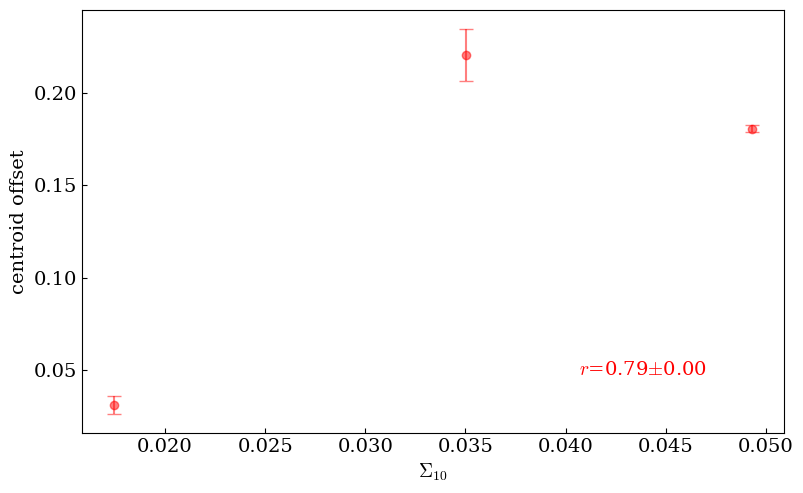

In [13]:
# plot for all the four cases of centroid offset vs. Sigmas

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
fig.tight_layout()

scatter_errbar_plot(Sigma_10_dset, center_diffs, sigma_center_diffs,
                    ['S_10', 'centroid_offset'], r_centroid_off_Sigma_10, ax)

plt.show()
fig.savefig("../paper/figures/centroid_offset_vs_Sigma_10.pdf", bbox_inches="tight")

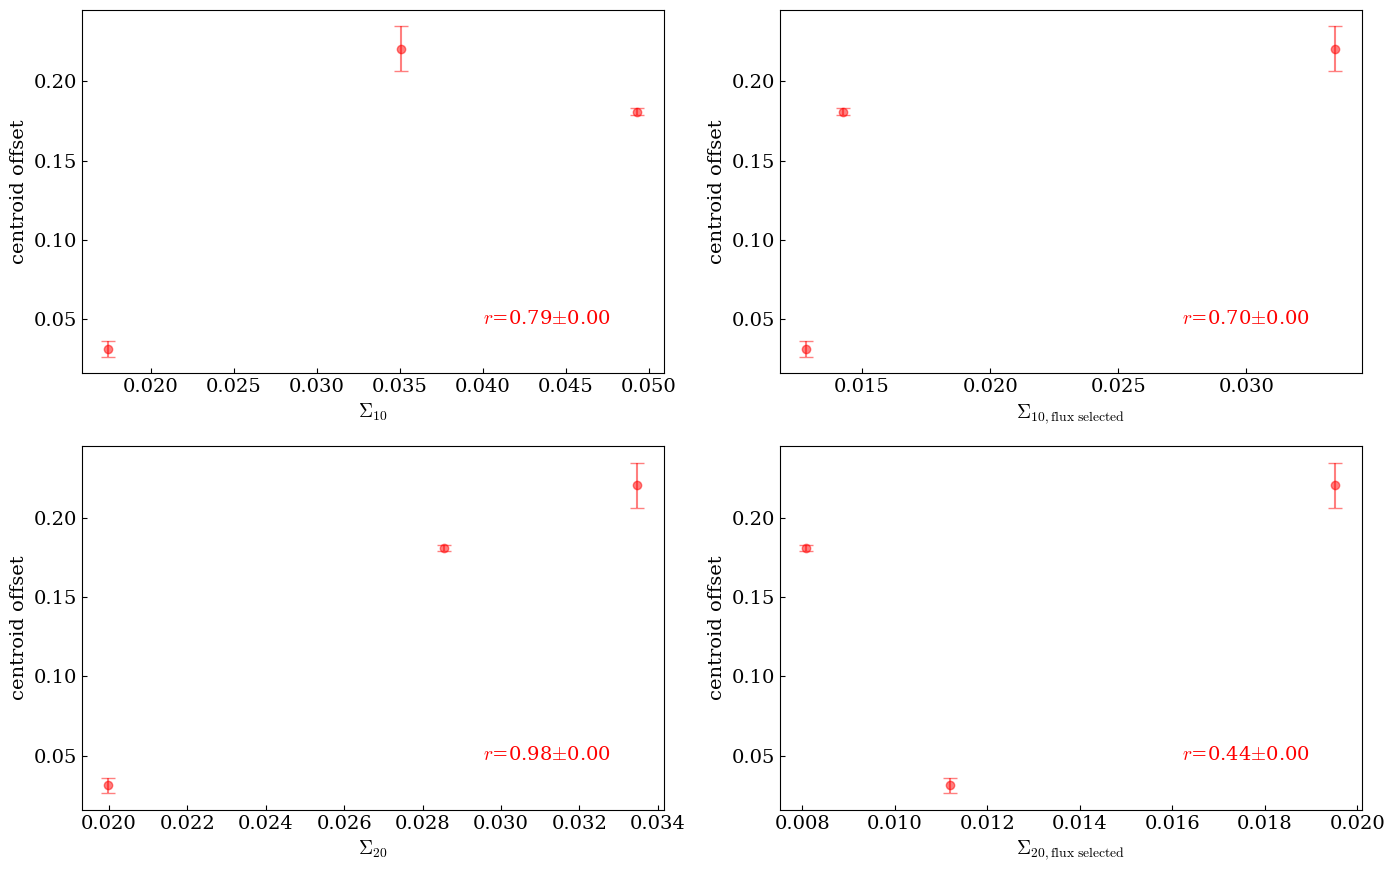

In [14]:
# plot for all the four cases of centroid offset vs. Sigmas

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
fig.tight_layout()
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)


scatter_errbar_plot(Sigma_10_dset, center_diffs, sigma_center_diffs,
                    ['S_10', 'centroid_offset'], r_centroid_off_Sigma_10, ax1)
scatter_errbar_plot(Sigma_10fs_dset, center_diffs, sigma_center_diffs,
                    ['S_10fs', 'centroid_offset'], r_centroid_off_Sigma_10fs, ax2)
scatter_errbar_plot(Sigma_20_dset, center_diffs, sigma_center_diffs,
                    ['S_20', 'centroid_offset'], r_centroid_off_Sigma_20, ax3)
scatter_errbar_plot(Sigma_20fs_dset, center_diffs, sigma_center_diffs,
                    ['S_20fs', 'centroid_offset'], r_centroid_off_Sigma_20fs, ax4)

plt.show()
fig.savefig("../paper/figures/centroid_offset_vs_Sigma_all.pdf", bbox_inches="tight")

### Position angle offset vs. $\Sigma$ cases

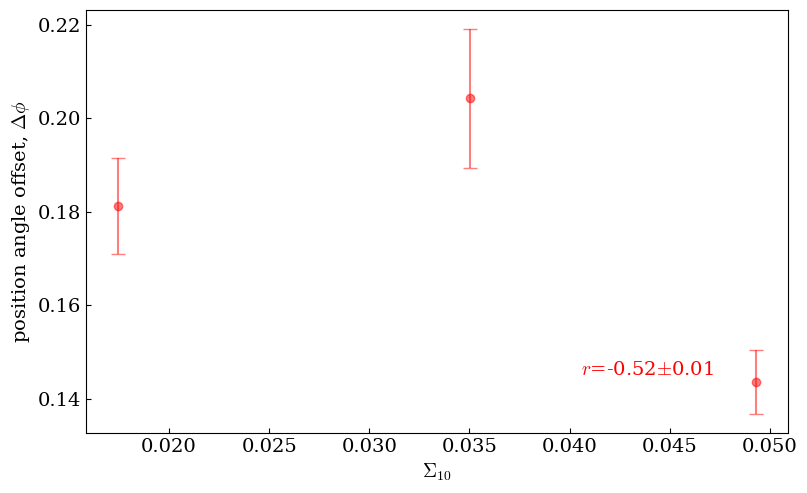

In [15]:
# plot for all the four cases of centroid offset vs. Sigmas

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
fig.tight_layout()

scatter_errbar_plot(Sigma_10_dset, dphis, sigma_dphis,
                    ['S_10', 'position_angle_offset'], r_dphi_Sigma_10, ax)

plt.show()
fig.savefig("../paper/figures/position_angle_offset_vs_Sigma_10.pdf", bbox_inches="tight")

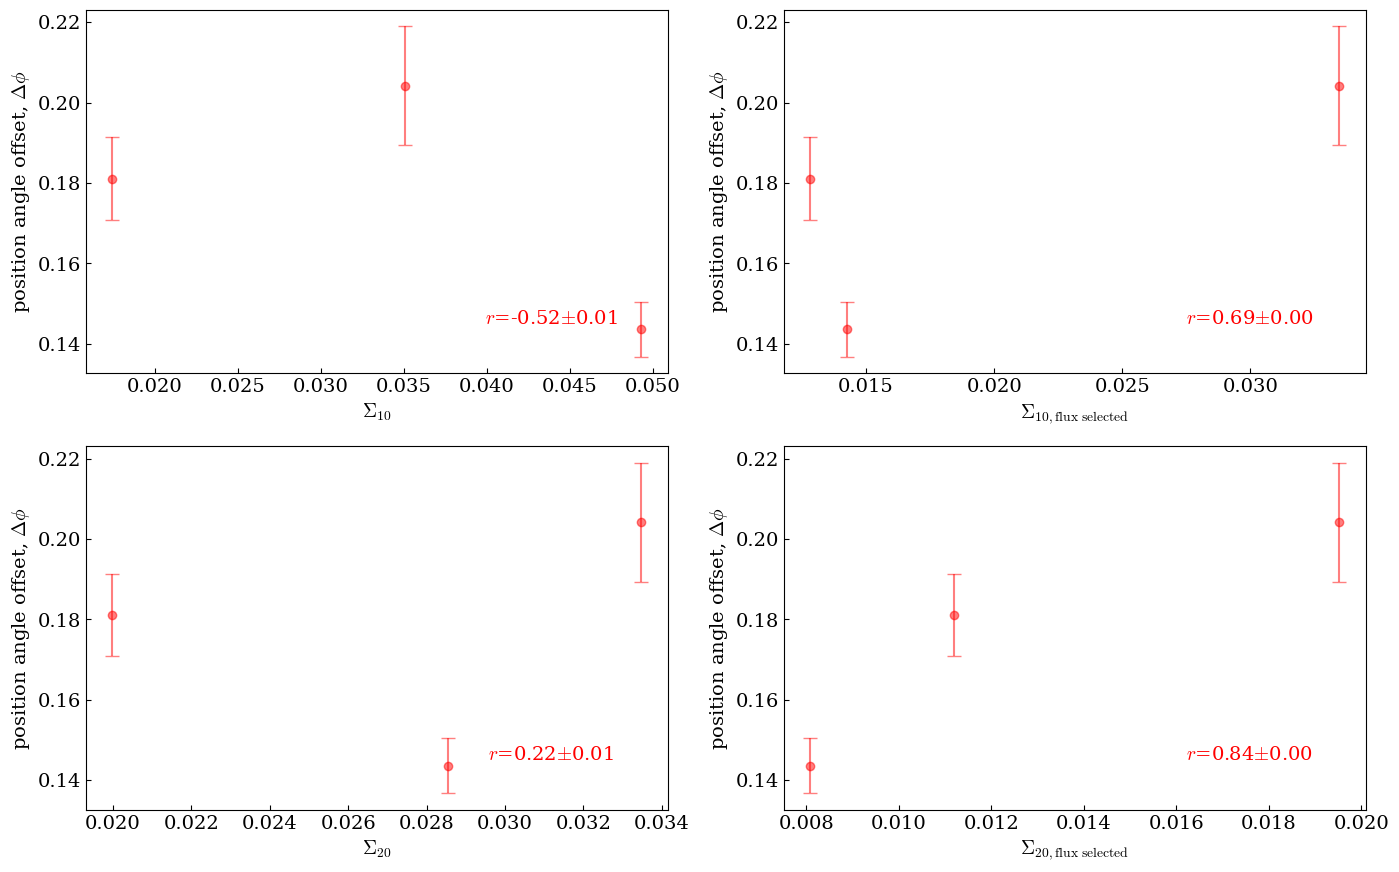

In [16]:
# plot for all the four cases of position angle offset vs. Sigmas

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
fig.tight_layout()
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)


scatter_errbar_plot(Sigma_10_dset, dphis, sigma_dphis,
                    ['S_10', 'position_angle_offset'], r_dphi_Sigma_10, ax1)
scatter_errbar_plot(Sigma_10fs_dset, dphis, sigma_dphis,
                    ['S_10fs', 'position_angle_offset'], r_dphi_Sigma_10fs, ax2)
scatter_errbar_plot(Sigma_20_dset, dphis, sigma_dphis,
                    ['S_20', 'position_angle_offset'], r_dphi_Sigma_20, ax3)
scatter_errbar_plot(Sigma_20fs_dset, dphis, sigma_dphis,
                    ['S_20fs', 'position_angle_offset'], r_dphi_Sigma_20fs, ax4)

plt.show()
fig.savefig("../paper/figures/position_angle_offset_vs_Sigma_all.pdf", bbox_inches="tight")